# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [202]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import make_scorer, recall_score



import warnings
from sklearn import set_config
set_config(display='diagram')



In [203]:
os.makedirs('logs', exist_ok=True)
os.makedirs('images', exist_ok=True)

In [204]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [205]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [207]:
print (df.isnull().sum())
print(df.shape)


age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64
(41188, 21)


In [208]:
df = df.drop(columns=['duration'])
df.shape

(41188, 20)

In [209]:
categorical_cols = df.select_dtypes(include=['object']).columns.to_list()
print(categorical_cols)
for col in categorical_cols :
    unique_values = df[col].unique()
    print(f" Unique values in {col} : {unique_values} \n")
categorical_cols.remove('y')
print(categorical_cols)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
 Unique values in job : ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student'] 

 Unique values in marital : ['married' 'single' 'divorced' 'unknown'] 

 Unique values in education : ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate'] 

 Unique values in default : ['no' 'unknown' 'yes'] 

 Unique values in housing : ['no' 'yes' 'unknown'] 

 Unique values in loan : ['no' 'yes' 'unknown'] 

 Unique values in contact : ['telephone' 'cellular'] 

 Unique values in month : ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep'] 

 Unique values in day_of_week : ['mon' 'tue' 'wed' 'thu' 'fri'] 

 Unique values in poutcome : ['nonexistent' 'failure' 'success'] 

 Unique values in y : ['no' 'yes'] 

['job', 'marital', '

In [210]:
#Getting ststical distribution by using describe()
df.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Text(0.5, 1.0, 'Marketing Campaing Success Rate Distribution')

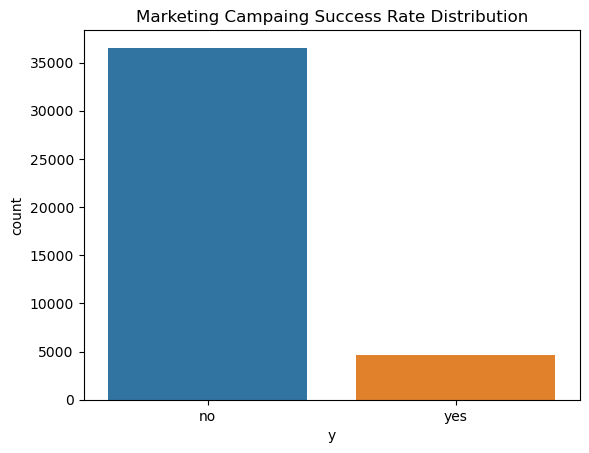

In [211]:
# Checking if data is balanced
sns.countplot(data=df, x ='y', hue='y')
plt.title('Marketing Campaing Success Rate Distribution')

### Problem 6: Train/Test Split, Encoding and Scalling

With your data prepared, split it into a train and test set.

In [212]:
print (df.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')


In [213]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis=1), df['y'], random_state=42, stratify=df.y, test_size=0.2)

print(f" \nChecking if Target is properly distributed among train and test splits \n")

print (f" y_train value counts : { y_train.value_counts(normalize=True)}")
print (f" y_test value counts : { y_test.value_counts(normalize=True)}")

 
Checking if Target is properly distributed among train and test splits 

 y_train value counts : y
no     0.887344
yes    0.112656
Name: proportion, dtype: float64
 y_test value counts : y
no     0.887351
yes    0.112649
Name: proportion, dtype: float64


In [214]:
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)

In [215]:
print (y_train)


25611     no
26010     no
40194    yes
297       no
36344     no
        ... 
40205     no
27316     no
14392     no
7494      no
10747     no
Name: y, Length: 32950, dtype: object


In [216]:
transformer = make_column_transformer((OneHotEncoder(drop='if_binary'), categorical_cols), remainder=StandardScaler())
#transformer = ColumnTransformer(transformers= [('cat' , OneHotEncoder(drop='if_binary'), categorical_cols), ('num', StandardScaler())


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

Using Dummy Classified with "Stratified" to get baseline model score

Description: This model makes predictions based on the distribution of classes in the training data. For instance, if 70% of your training data belongs to class A and 30% to class B, this model will randomly predict class A 70% of the time and class B 30% of the time.

In [217]:
baseline_pipe = Pipeline([('transform', transformer),
                          ('dummy_strat' , DummyClassifier(strategy='stratified', random_state=42))])


In [218]:
%%time
baseline_pipe.fit(X_train,y_train)


CPU times: user 186 ms, sys: 6.86 ms, total: 193 ms
Wall time: 67 ms


Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('dummy_strat',
                 DummyClassifier(random_state=42, strategy='stratified'))])

In [219]:
print(f" Baseline Accuracy Score (Stratified) : { accuracy_score(y_test, baseline_pipe.predict(X_test)) : .4f}")

 Baseline Accuracy Score (Stratified) :  0.8037


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [220]:
logreg_pipe = Pipeline([('transform', transformer),
                        ('Logreg' , LogisticRegression(random_state=42))])

In [221]:
%%time
logreg_pipe.fit(X_train,y_train)

CPU times: user 1.81 s, sys: 14.3 ms, total: 1.82 s
Wall time: 321 ms


Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('Logreg', LogisticRegression(random_state=42))])

### Problem 9: Score the Model

What is the accuracy of your model?

In [222]:
logreg_train_accuracy = accuracy_score(y_train, logreg_pipe.predict(X_train))
logreg_test_accuracy = accuracy_score(y_test, logreg_pipe.predict(X_test))

print(F"Logistic Regression Training Accuracy : { logreg_train_accuracy : .4f}")
print(F"Logistic Regression Test Accuracy : { logreg_test_accuracy : .4f}")


Logistic Regression Training Accuracy :  0.8999
Logistic Regression Test Accuracy :  0.9008


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|  Base  | 0.072s   |.   8037  |.   NA  |
|  Logistic Regrssion  | 0.28s   |.   8999  |.   9008  |
|  KNN  | 0.085s   |.   9123  |.  8961   |
|  Decision Tree  | 0.223s   |.   9954  |.   8450  |
|  Support Vector Machine(SVM)  | 41.68s   |.   9049  |.   9035  |

In [223]:
def eval_mdl(model, X_tr, y_tr, X_te, y_te, m_name,output_file):
    P_flag = True
    print(f"Running model : {m_name}\n")
    outlog = 'logs/' + output_file + 'default_log.txt'
    imagelog = 'images/' + output_file
    with open(outlog, 'a') as f:
        f.write (f"Running model :  {m_name}\n")

    model_pipe = Pipeline([('transform', transformer),('m_classfier', model)])
    start_time = time.time()
    model_pipe.fit(X_tr, y_tr)
    end_time = time.time()
    fit_time = end_time - start_time
    train_accuracy = accuracy_score(y_tr, model_pipe.predict(X_tr))
    test_accuracy = accuracy_score(y_te, model_pipe.predict(X_te))
    model_confusion_matrix = confusion_matrix(y_te, model_pipe.predict(X_te), labels=['no', 'yes'])
    with open(outlog, 'a') as f:
        f.write(f" {m_name} fit time : {fit_time:.4f}, Training Accuracy : {train_accuracy: .4f}, Test Accuracy: {test_accuracy:.4f}\n")
        f.write(f"{m_name} Classification report : \n {classification_report(y_te, model_pipe.predict(X_te) )}\n")
        f.write(f"{m_name} Confusion Matrix : \n {model_confusion_matrix}\n")

    if P_flag:
        print(f" {m_name} fit time : {fit_time:.4f}, Training Accuracy : {train_accuracy: .4f}, Test Accuracy: {test_accuracy:.4f}")
        print(f"{m_name} Classification report : \n {classification_report(y_te, model_pipe.predict(X_te) )}")
        print(f"{m_name} Confusion Matrix : \n {model_confusion_matrix}")
    disp = ConfusionMatrixDisplay(model_confusion_matrix, display_labels=['no','yes'])
    disp.plot()
    plt.title(m_name + "_confusion_matrix")
    plt.savefig(f'{imagelog}_{m_name}_default_confusion_matrix.png')
    if P_flag:
        plt.show()
    plt.close()


In [224]:
models = {
    'Logreg' : LogisticRegression(random_state=42),
    'knn' : KNeighborsClassifier(),
    'dtree' : DecisionTreeClassifier(random_state=42),
    'svm' : SVC(random_state=42)
}
for name, model in models.items():
    eval_mdl(model, X_train, y_train, X_test, y_test, name, 'Accuracy')

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [225]:
numeric_columns = df.select_dtypes(include=['int64','float64']).columns.to_list()
print(numeric_columns)

['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


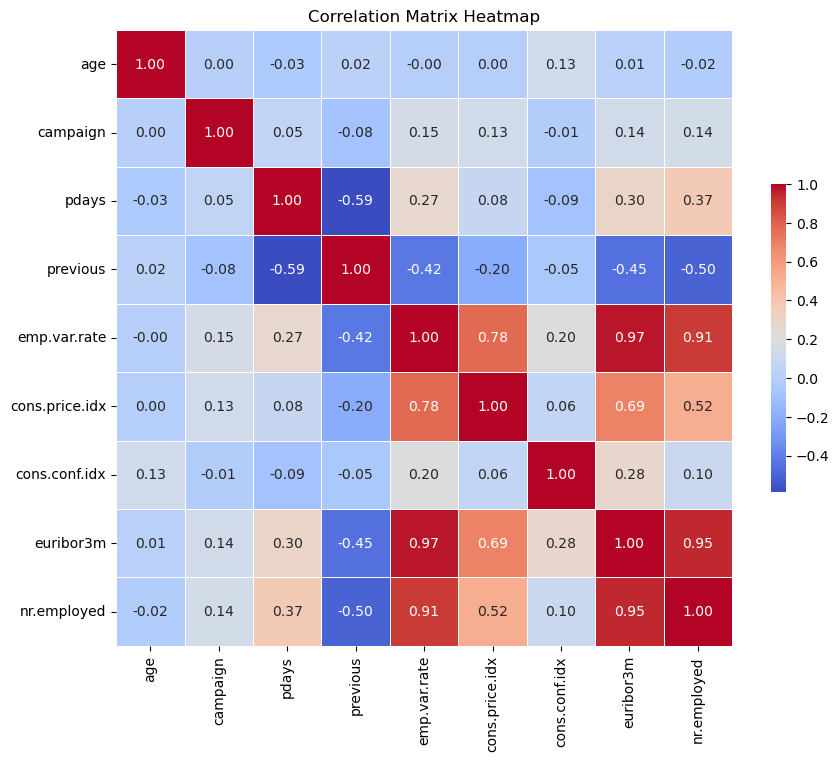

In [226]:
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix Heatmap')
plt.show()

	1.	Highly Correlated Features:
	•	emp.var.rate and euribor3m have a very high correlation (r = 0.97).
	•	emp.var.rate and nr.employed also have a very high correlation (r = 0.91).
	•	euribor3m and nr.employed are highly correlated (r = 0.95).

In [227]:
#dropping emp.var.rate
df.drop(columns=['emp.var.rate','euribor3m'], inplace=True)
numeric_columns = df.select_dtypes(include=['int64','float64']).columns.to_list()


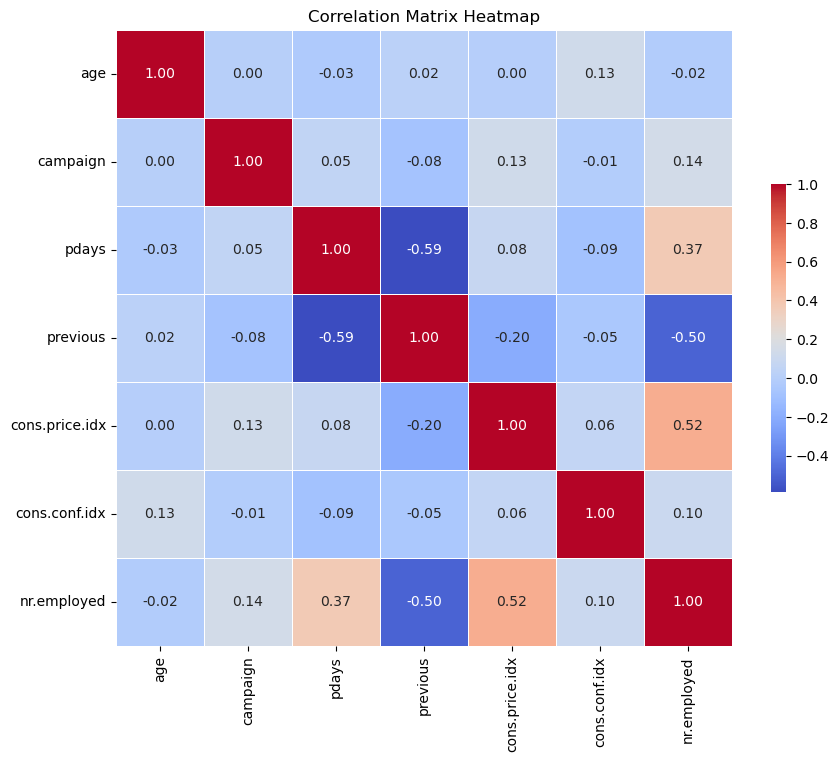

In [228]:
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix Heatmap')
plt.show()

### using SFS to reduce featurs


In [271]:
# Define the pipeline
# pipeline = Pipeline(steps=[
#     ('transform', transformer),
#     ('classifier', LogisticRegression())
# ])
# pipeline.fit(X_train, y_train)
# # Apply Sequential Feature Selector (SFS)
recall_scorer = make_scorer(recall_score, pos_label = 'yes')


sfs = SequentialFeatureSelector(
    estimator=LogisticRegression(max_iter=1000),  # the model after preprocessing
    n_features_to_select=10,  # number of features to select, adjust as necessary
    direction='forward',     # forward selection, could also use 'backward'
    # scoring=recall_scorer,      # scoring metric, adjust as necessary
    scoring='accuracy',      # scoring metric, adjust as necessary
    cv=5                     # cross-validation strategy
)

# Fit the SFS on the preprocessed data
X_train_transformed = transformer.fit_transform(X_train)
# X_test_transformed = transformer.fit_transform(X_test)
sfs.fit(X_train_transformed, y_train)

# Selected features
selected_features = sfs.get_support(indices=True)
print("Selected features:", selected_features)

Selected features: [ 0 13 17 20 27 29 34 41 54 60]


In [272]:
X_test_transformed = transformer.transform(X_test)


In [273]:
feature_names = transformer.get_feature_names_out()
# print(feature_names)
selected_feature_names = feature_names[selected_features]
# print("Selected feature names:", selected_feature_names)


In [274]:
X_train_selected = X_train_transformed[:,selected_features]
X_test_selected = X_test_transformed[:,selected_features]


In [275]:
param_grid =  {
    # 'Logreg' :  {'Logreg__C' : [0.1,1,10,100],
    #           'Logreg__max_iter' : [5000],
    #           "Logreg__penalty": ["l1", "l2", "elasticnet", none],
    #           "Logreg__solver": ["liblinear", "saga"],
    #         #   "Logreg__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    #           },
    'Logreg': {
        # 'Logreg__C': [0.01, 0.1, 1, 10, 100],
        'Logreg__C': [0.01, 0.1, 1, 10, 100],
        'Logreg__max_iter': [200,300,500],
        'Logreg__penalty': ['l1', 'l2'],
        'Logreg__solver': ['liblinear'],
    },
    'Logreg_others': {
        # 'Logreg_others__C': [0.1, 1, 10, 100],
        'Logreg_others__max_iter': [5000],
        # 'Logreg_others__penalty': ['l2', None],
        'Logreg_others__penalty': [None],
        'Logreg_others__solver': ['newton-cg', 'lbfgs', 'sag'],
    },
    'Logreg_saga': {
        # 'Logreg_saga__C': [0.1, 1, 10, 100],
        'Logreg_saga__C': [0.1, 1],
        'Logreg_saga__max_iter': [1000],
        'Logreg_saga__penalty': ['elasticnet'],
        'Logreg_saga__solver': ['saga'],
        # 'Logreg_saga__l1_ratio': [0.1, 0.5, 0.7, 0.9],  # Add l1_ratio for elasticnet
        'Logreg_saga__l1_ratio': [0.7, 0.9],  # Add l1_ratio for elasticnet
    },
    'knn' : {'knn__n_neighbors' : range(15,23,2),
              'knn__weights' : ['uniform','distance'], 
            #   "knn__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
              'knn__p': [1,2]
              },
    'dtree' : {'dtree__max_depth' : np.arange(4,10,2),
                'dtree__min_samples_split' : [2,4,6],
                'dtree__criterion' : ['gini', 'entropy'],
                'dtree__min_samples_leaf' : [15,20,25]},
    # 'svm' : {'svm__kernel' : ['rbf', 'poly','linear','sigmoid'],
    #           'svm__C' : [0.1, 1, 10, 100],
    #           'svm__gamma' : [0.1,1, 10, 100] }
    'svm_rbf' : {'svm_rbf__kernel' : ['rbf'],
              'svm_rbf__C' : [0.1, 1,10,100 ],
              'svm_rbf__gamma' : [0.01,0.1,1,10] },
    'svm_linear' : {'svm_linear__kernel' : ['linear'],
              'svm_linear__C' : [0.1, 1 ]},
    'svm_poly' : {'svm_poly__kernel' : ['poly'],
              'svm_poly__C' : [0.1, 1 ],
              'svm_poly__gamma' : [0.1,1],
               'svm_poly__degree' : [2,3] }
              
}

In [276]:
def eval_optimized_mdl(model, X_tr, y_tr, X_te, y_te, m_name,p_grid, p_dict, output_file):
    # model_pipe = Pipeline([('transform', transformer),
    #                         ('feature_selection', SequentialFeatureSelector(
    #                             estimator=LogisticRegression(max_iter=1000),
    #                             n_features_to_select=5,
    #                             direction='forward',
    #                             scoring='accuracy',
    #                             cv=5
    #                             )),
    #                        (m_name, model)])
    P_flag = True  # Print flag
    print(f"Running model : {m_name}\n")
    outlog = 'logs/' + output_file + 'Grid_log.txt'
    imagelog = 'images/' + output_file
    with open(outlog, 'a') as f:
        f.write (f"Running model :  {m_name}\n")
    
    model_pipe = Pipeline([
                           (m_name, model)])
    model_grid = GridSearchCV(model_pipe, p_grid[m_name],cv=5, refit=True, scoring='accuracy', verbose=1)
    # model_grid = GridSearchCV(model_pipe, p_grid[m_name],cv=5, refit=True, scoring=recall_scorer, verbose=1)
    start_time = time.time()
    model_grid.fit(X_tr, y_tr)
    end_time = time.time()
    fit_time = end_time - start_time
    train_accuracy = accuracy_score(y_tr, model_grid.best_estimator_.predict(X_tr))
    test_accuracy = accuracy_score(y_te, model_grid.best_estimator_.predict(X_te))
    p_dict[str(m_name)] = model_grid.best_estimator_.predict_proba(X_te)
    model_confusion_matrix = confusion_matrix(y_te, model_grid.best_estimator_.predict(X_te), labels=['no', 'yes'])
    with open(outlog, 'a') as f :
        f.write(f" {m_name} fit time : {fit_time:.4f}, Training Accuracy : {train_accuracy: .4f}, Test Accuracy: {test_accuracy:.4f}\n")
        f.write(f" {m_name} best_params : { model_grid.best_params_}\n")
        f.write(f"{m_name} Classification report : \n {classification_report(y_te, model_grid.best_estimator_.predict(X_te) )}\n")
        f.write(f"{m_name} Confusion Matrix : \n {model_confusion_matrix}\n")

    if P_flag:
        print(f" {m_name} fit time : {fit_time:.4f}, Training Accuracy : {train_accuracy: .4f}, Test Accuracy: {test_accuracy:.4f}")
        print(f" {m_name} best_params : { model_grid.best_params_}")
        print(f"{m_name} Classification report : \n {classification_report(y_te, model_grid.best_estimator_.predict(X_te) )}")
        print(f"{m_name} Confusion Matrix : \n {model_confusion_matrix}")
    
    disp = ConfusionMatrixDisplay(model_confusion_matrix, display_labels=['no','yes'])
    disp.plot()
    plt.title(m_name + "_confusion_matrix")
    plt.savefig(f'{imagelog}_{m_name}_Grid_confusion_matrix.png')
    if P_flag:
        plt.show()
    plt.close()

Running model : Logreg

Fitting 5 folds for each of 30 candidates, totalling 150 fits
 Logreg fit time : 15.1993, Training Accuracy :  0.8996, Test Accuracy: 0.8997
 Logreg best_params : {'Logreg__C': 1, 'Logreg__max_iter': 200, 'Logreg__penalty': 'l2', 'Logreg__solver': 'liblinear'}
Logreg Classification report : 
               precision    recall  f1-score   support

          no       0.90      0.99      0.95      7310
         yes       0.72      0.18      0.29       928

    accuracy                           0.90      8238
   macro avg       0.81      0.58      0.62      8238
weighted avg       0.88      0.90      0.87      8238

Logreg Confusion Matrix : 
 [[7247   63]
 [ 763  165]]


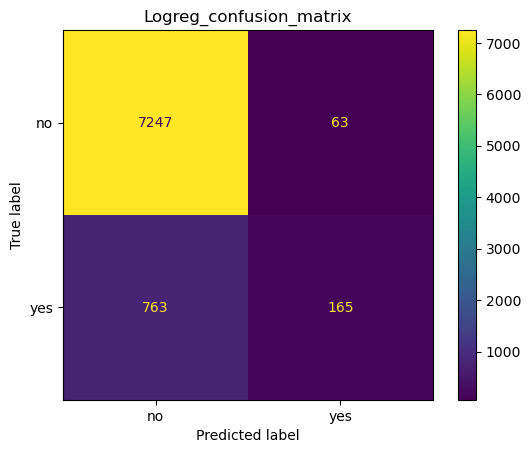

Running model : Logreg_others

Fitting 5 folds for each of 3 candidates, totalling 15 fits
 Logreg_others fit time : 5.4711, Training Accuracy :  0.8996, Test Accuracy: 0.8997
 Logreg_others best_params : {'Logreg_others__max_iter': 5000, 'Logreg_others__penalty': None, 'Logreg_others__solver': 'lbfgs'}
Logreg_others Classification report : 
               precision    recall  f1-score   support

          no       0.90      0.99      0.95      7310
         yes       0.72      0.18      0.29       928

    accuracy                           0.90      8238
   macro avg       0.81      0.58      0.62      8238
weighted avg       0.88      0.90      0.87      8238

Logreg_others Confusion Matrix : 
 [[7247   63]
 [ 763  165]]


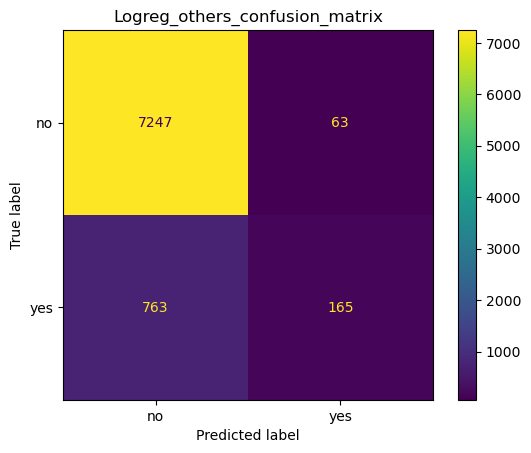

Running model : Logreg_saga

Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Logreg_saga fit time : 3.8967, Training Accuracy :  0.8996, Test Accuracy: 0.8997
 Logreg_saga best_params : {'Logreg_saga__C': 1, 'Logreg_saga__l1_ratio': 0.7, 'Logreg_saga__max_iter': 1000, 'Logreg_saga__penalty': 'elasticnet', 'Logreg_saga__solver': 'saga'}
Logreg_saga Classification report : 
               precision    recall  f1-score   support

          no       0.90      0.99      0.95      7310
         yes       0.72      0.18      0.29       928

    accuracy                           0.90      8238
   macro avg       0.81      0.58      0.62      8238
weighted avg       0.88      0.90      0.87      8238

Logreg_saga Confusion Matrix : 
 [[7247   63]
 [ 763  165]]


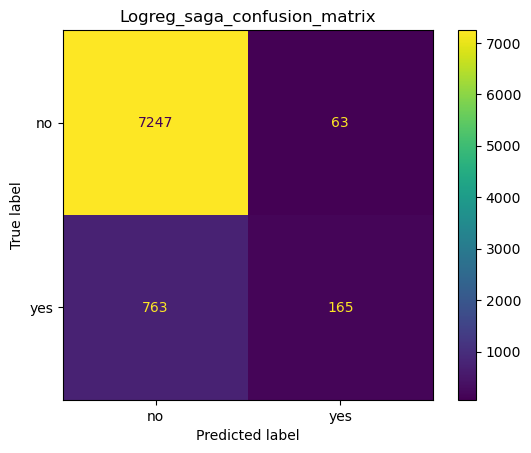

Running model : knn

Fitting 5 folds for each of 16 candidates, totalling 80 fits
 knn fit time : 21.1871, Training Accuracy :  0.8994, Test Accuracy: 0.8982
 knn best_params : {'knn__n_neighbors': 15, 'knn__p': 2, 'knn__weights': 'uniform'}
knn Classification report : 
               precision    recall  f1-score   support

          no       0.91      0.98      0.94      7310
         yes       0.63      0.23      0.34       928

    accuracy                           0.90      8238
   macro avg       0.77      0.61      0.64      8238
weighted avg       0.88      0.90      0.88      8238

knn Confusion Matrix : 
 [[7187  123]
 [ 716  212]]


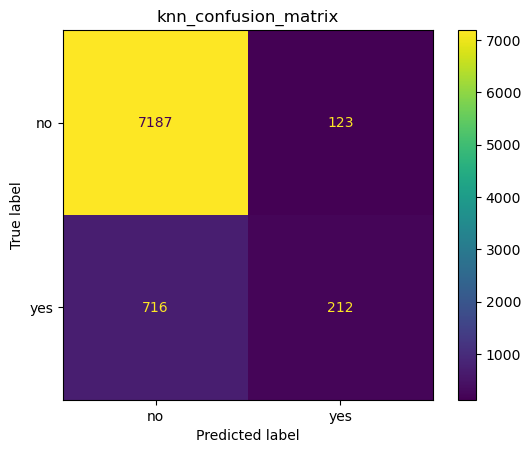

Running model : dtree

Fitting 5 folds for each of 54 candidates, totalling 270 fits
 dtree fit time : 6.8486, Training Accuracy :  0.8994, Test Accuracy: 0.9002
 dtree best_params : {'dtree__criterion': 'entropy', 'dtree__max_depth': 4, 'dtree__min_samples_leaf': 15, 'dtree__min_samples_split': 2}
dtree Classification report : 
               precision    recall  f1-score   support

          no       0.91      0.99      0.95      7310
         yes       0.73      0.18      0.29       928

    accuracy                           0.90      8238
   macro avg       0.82      0.59      0.62      8238
weighted avg       0.89      0.90      0.87      8238

dtree Confusion Matrix : 
 [[7246   64]
 [ 758  170]]


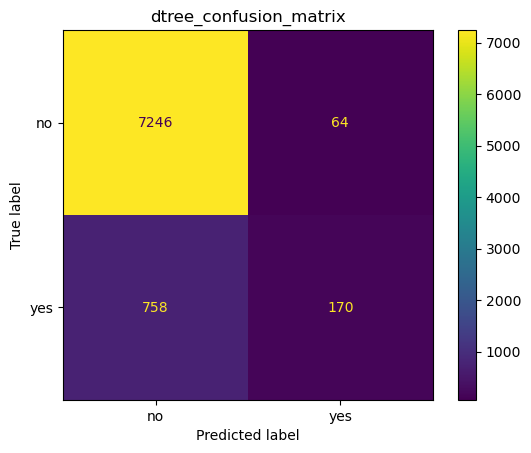

Running model : svm_rbf

Fitting 5 folds for each of 16 candidates, totalling 80 fits
 svm_rbf fit time : 1965.2210, Training Accuracy :  0.8998, Test Accuracy: 0.8995
 svm_rbf best_params : {'svm_rbf__C': 1, 'svm_rbf__gamma': 0.1, 'svm_rbf__kernel': 'rbf'}
svm_rbf Classification report : 
               precision    recall  f1-score   support

          no       0.90      0.99      0.95      7310
         yes       0.73      0.17      0.27       928

    accuracy                           0.90      8238
   macro avg       0.82      0.58      0.61      8238
weighted avg       0.88      0.90      0.87      8238

svm_rbf Confusion Matrix : 
 [[7253   57]
 [ 771  157]]


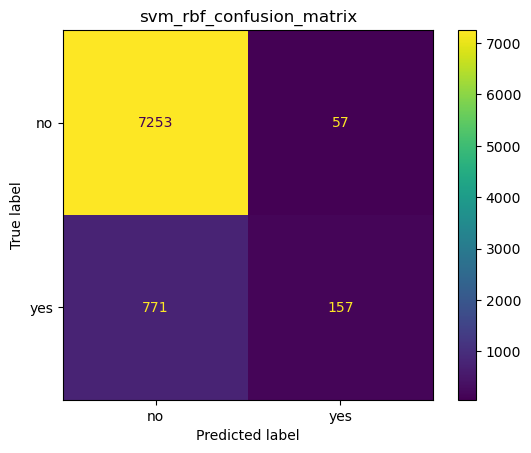

Running model : svm_linear

Fitting 5 folds for each of 2 candidates, totalling 10 fits
 svm_linear fit time : 278.8487, Training Accuracy :  0.8975, Test Accuracy: 0.8977
 svm_linear best_params : {'svm_linear__C': 0.1, 'svm_linear__kernel': 'linear'}
svm_linear Classification report : 
               precision    recall  f1-score   support

          no       0.91      0.99      0.94      7310
         yes       0.65      0.20      0.31       928

    accuracy                           0.90      8238
   macro avg       0.78      0.59      0.63      8238
weighted avg       0.88      0.90      0.87      8238

svm_linear Confusion Matrix : 
 [[7208  102]
 [ 741  187]]


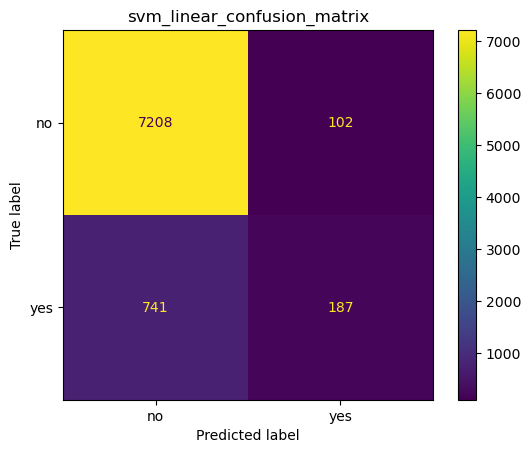

In [277]:
models = {
    'Logreg' : LogisticRegression(random_state=42),
    'Logreg_others' : LogisticRegression(random_state=42),
    'Logreg_saga' : LogisticRegression(random_state=42),
    'knn' : KNeighborsClassifier(),
    'dtree' : DecisionTreeClassifier(random_state=42),
    'svm_rbf' : SVC(random_state=42, probability=True),
    'svm_linear' : SVC(random_state=42, probability=True),
    # 'svm_poly' : SVC(random_state=42)
}
proba_dict = {}
for name, model in models.items():
    eval_optimized_mdl(model, X_train_selected, y_train, X_test_selected, y_test, name, param_grid, proba_dict, 'Accuracy_10fwd')
    # eval_optimized_mdl(model, X_train, y_train, X_test, y_test, name, param_grid)

### ROC Curve


In [278]:
labels = {
    'Logreg' :'LogReg Norm',
    'Logreg_others' : 'LogReg Others',
    'Logreg_saga' : 'LogReg Saga',
    'knn' : 'KNN',
    'dtree' : 'Decision Tree',
    'svm_rbf' : 'SVM RBF',
    'svm_linear' : 'SVM Linear',
    # 'svm_poly' : 'SVM Poly'
}

colors = {
    'Logreg': 'darkorange',
    'Logreg_others': 'darkblue',
    'Logreg_saga': 'magenta',
    'knn': 'purple',
    'dtree': 'darkcyan',
    'svm_rbf': 'crimson',
    'svm_linear': 'seagreen',
    'svm_poly': 'goldenrod'
}


In [279]:
def plot_roc_curves(proba_dict, y_test, labels, colors):
    plt.figure()
    
    for model_name, probs in proba_dict.items():
        fpr, tpr, _ = roc_curve(y_test, probs[:, 1], pos_label='yes')
        auc = roc_auc_score(y_test, probs[:, 1])
        color = colors.get(model_name, 'black')  # Default color is black if not provided
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{labels[model_name]} ROC curve (area = {auc:.2f})')
    
    # Plot the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('images/ROC_curve_AC10FWD.png')
    plt.show()
    plt.close()

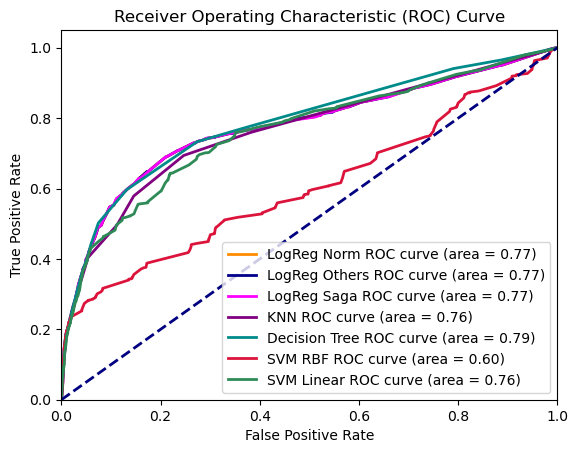

In [280]:
plot_roc_curves(proba_dict, y_test, labels, colors)


In [281]:
# models = {
#     # 'Logreg' : LogisticRegression(random_state=42),
#     # 'Logreg_others' : LogisticRegression(random_state=42),
#     # 'Logreg_saga' : LogisticRegression(random_state=42),
#     # 'knn' : KNeighborsClassifier(),
#     # 'dtree' : DecisionTreeClassifier(random_state=42),
#     'svm' : SVC(random_state=42)
# }
# for name, model in models.items():
#     eval_optimized_mdl(model, X_train, y_train, X_test, y_test, name, param_grid)

In [282]:
logreg_params = {'Logreg__C' : [0.01,0.1,1,10,100],
              'Logreg__max_iter' : [100,200,300]}
logreg_grid = GridSearchCV(estimator=logreg_pipe, param_grid=logreg_params,refit=True)

In [283]:
%%time
logreg_grid.fit(X_train,y_train)

CPU times: user 2min 13s, sys: 12.6 s, total: 2min 26s
Wall time: 20.1 s


GridSearchCV(estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome'])])),
                                       ('Logreg',
                                        LogisticRegression(random_state=42))]),
             param_grid={'Logreg__C': [0.01, 0.1, 1, 10, 100],
                         'Logreg__max_iter': [100, 200, 300]})

In [284]:
print (f" Logistic Regression best params : { logreg_grid.best_params_}")
logreg_train_accuracy = accuracy_score(y_train, logreg_grid.best_estimator_.predict(X_train))
logreg_test_accuracy = accuracy_score(y_test, logreg_grid.best_estimator_.predict(X_test))

print(F"Logistic Regression Training Accuracy : { logreg_train_accuracy : .4f}")
print(F"Logistic Regression Test Accuracy : { logreg_test_accuracy : .4f}")


 Logistic Regression best params : {'Logreg__C': 0.1, 'Logreg__max_iter': 100}
Logistic Regression Training Accuracy :  0.9003
Logistic Regression Test Accuracy :  0.9018


##### Questions